In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import yfinance as yf
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from keras import Input
from keras import layers, Model
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import random
import sys
sys.path.append('../..')
#import ep.etools as apt
# import warnings
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset,BusinessDay

,Day-ahead,Month-ahead,Quarter-ahead,Summer 24,Winter 24,Year-Ahead,2 Year-Ahead
date_m,,,,,,,
2010-01-01,14.30,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,16.25,13.70,NaN,NaN,NaN,NaN,NaN
2010-01-05,14.15,13.96,NaN,NaN,NaN,NaN,NaN
2010-01-06,14.65,13.80,NaN,NaN,NaN,NaN,NaN
2010-01-07,16.18,13.82,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-03-08,26.34,26.39,26.51,NaN,NaN,30.19,28.67
2024-03-11,25.02,24.97,25.10,25.33,29.56,29.19,27.78
2024-03-12,25.01,24.82,24.94,25.18,29.24,28.82,27.46


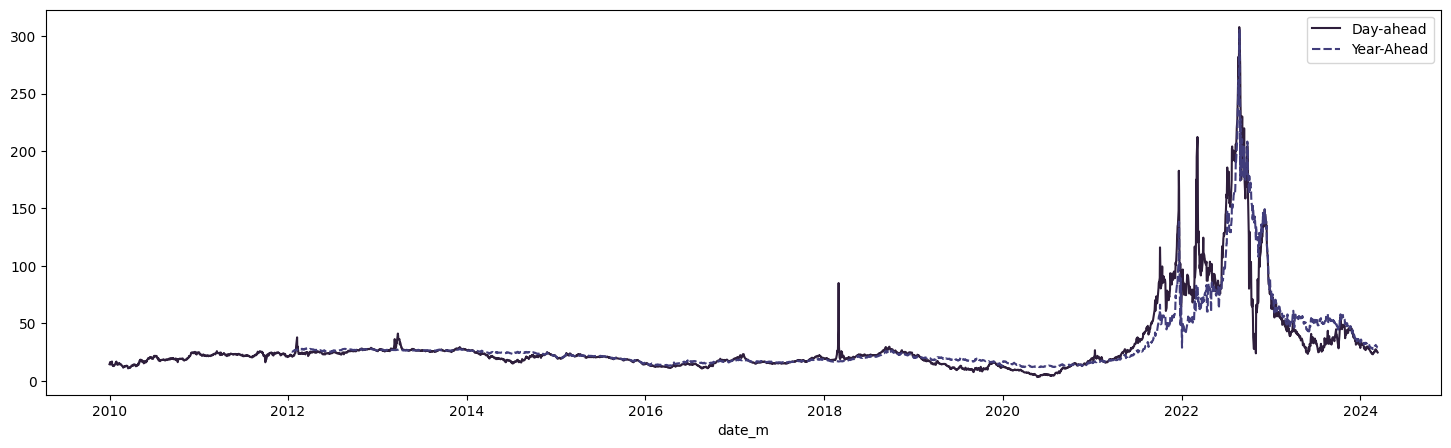

In [12]:
# dataCalendar = pd.read_csv('./data/bloc_ttf_calendar_prices.csv')
dataPrices = pd.read_csv('./data/bloc_ttf_prices.csv')
dataPrices['date_m'] = pd.to_datetime(dataPrices['date_m'])
dataPrices = dataPrices.set_index('date_m')
fig, ax = plt.subplots(figsize=(18,5))
# sns.set_palette("mako")
sns.lineplot(dataPrices[['Day-ahead','Year-Ahead']][0:-1], color='Blue'); #3390
#ax2 = plt.twinx()
#sns.lineplot(data=final['€/$'], ax=ax2 , color='grey')
dataPrices

# Lecture des informations de stock de Gaz depuis AGSI
* normalisation des données
* conversion en float
* conversion des dates

pour un Pays remplacer "type" par "country" et mettre en paramètre le code du pays : FR, BE, DE ...

In [25]:
import requests
params = {
    "type": "EU",
    "from": "2010-01-01",
    "size": 10000
}
header = {
  "x-key" : "99e18f932d22c9acf9c42f27d0b8b539" }

url = "https://agsi.gie.eu/api"
resp = requests.get(url=url, params=params, headers=header)
json = resp.json()
data = pd.json_normalize(json['data'])
data["gasInStorage"] = data["gasInStorage"].astype(float)
data["full"] = data["full"].astype(float)
#data["coveredCapacity"] = data["coveredCapacity"].astype(float)
pd.to_datetime(data['gasDayStart'], errors='coerce')
#data[["gasDayStart","gasInStorage"]]
#print(data)
print('Done')

Done


In [26]:
data

,name,code,url,updatedAt,gasDayStart,gasInStorage,consumption,consumptionFull,injection,withdrawal,...,workingGasVolume,injectionCapacity,withdrawalCapacity,contractedCapacity,availableCapacity,coveredCapacity,status,trend,full,info
0,EU,eu,eu,2024-03-14 19:08:16,2024-03-13,683.4358,3760.87,18.17,333.27,2636.5,...,1141.287,11654.97,19903.77,-,-,100,E,-0.2,59.88,[]
1,EU,eu,eu,2024-03-14 15:41:37,2024-03-12,685.7611,3760.87,18.23,282.4,3168,...,1141.287,11663.85,19936.21,-,-,100,E,-0.25,60.09,[]
2,EU,eu,eu,2024-03-14 14:19:35,2024-03-11,688.6649,3760.87,18.31,270.84,2990.3,...,1141.287,11663.73,19936.53,-,-,100,E,-0.24,60.34,[]
3,EU,eu,eu,2024-03-14 10:35:28,2024-03-10,691.4071,3760.87,18.38,802.59,1708.8,...,1141.287,11663.67,19943.69,-,-,100,C,-0.08,60.58,[]
4,EU,eu,eu,2024-03-14 10:37:01,2024-03-09,692.3210,3760.87,18.41,663.73,1899.5,...,1141.287,11663.61,19943.86,-,-,100,C,-0.11,60.66,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,EU,eu,eu,2023-04-18 10:46:51,2011-01-05,428.0276,3530,12.13,62.45,3640.9,...,617.5105,5392.47,10316.05,-,-,-,C,-0.58,69.32,[]
4817,EU,eu,eu,2023-04-18 10:46:51,2011-01-04,431.5952,3530,12.23,44.25,3829.5,...,617.5105,5392.62,10316.06,-,-,-,C,-0.6,69.89,[]
4818,EU,eu,eu,2023-04-18 10:46:51,2011-01-03,435.3212,3530,12.33,110.6,3323.2,...,617.5099,5392.74,10316.04,-,-,-,C,-0.51,70.50,[]
4819,EU,eu,eu,2023-04-18 10:46:51,2011-01-02,438.4398,3530,12.42,84.05,2091.4,...,617.5102,5392.84,10316.05,-,-,-,C,-0.32,71.00,[]


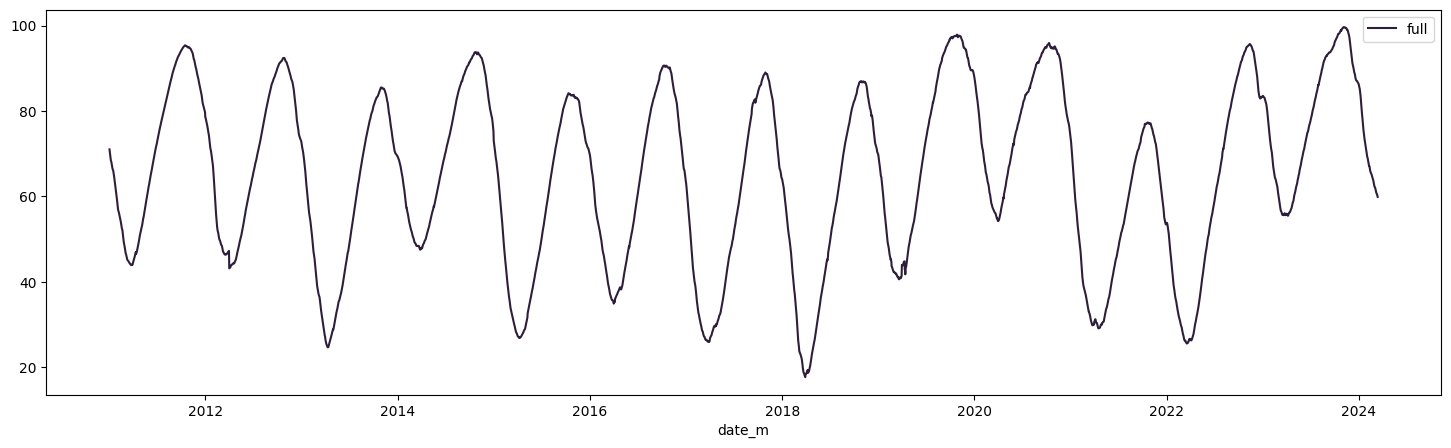

In [27]:
data['date_m'] = pd.to_datetime(data['gasDayStart'])
data = data.set_index('date_m')
fig, ax = plt.subplots(figsize=(18,5))
# sns.set_palette("mako")
sns.lineplot(data[['full']][0:-1], color='Blue'); #3390